In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
import csv
import random
import numpy as np
from PIL import Image as PIL_Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms
from torchvision.models import resnet50

# 랜덤 시드 고정

In [3]:
seed = 365

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)    
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
drivepath = "/content/gdrive/MyDrive"

# 모델과 그에 맞는 데이터셋 설정

기존의 Convolution layer에 더해서 이후 fc layer에 이전 n개의 입력을 추가하여 고려해서 다음 키 입력을 예측할 수 있도록 설계하였습니다.

In [5]:
window_size = 50      # 이전의 입력을 몇개까지 볼 것인가

In [6]:
class KartModel2(nn.Module):
  def __init__(self, class_num = 6):
    super(KartModel2, self).__init__()
    self.class_num = class_num
    self.backbone = resnet50(pretrained=True)
    self.backbone.fc = nn.Sequential(
      nn.Linear(in_features=2048, out_features=1000, bias=True),
    )
    self.fc_include_past_inputs = nn.Sequential(
        nn.Linear(in_features=1000+6*window_size, out_features=class_num, bias=True),
        nn.Sigmoid(),
    )
  
  def forward(self, input_image, past_inputs_10):
    out = self.backbone(input_image)
    out = self.fc_include_past_inputs(torch.cat((out, past_inputs_10), dim=1))
    return out

In [7]:
class KartDataSet2(data.Dataset):
  def __init__(self, csv_file):
    self.images = []
    self.labels = []

    with open(csv_file) as csvfile:
      csv_reader = csv.reader(csvfile)
      next(csv_reader, None)        # 첫번째 row 스킵
      
      for row in csv_reader:
        self.images.append(drivepath + '/' + row[0])
        self.labels.append([int(x) for x in list(row[1])])

  def __getitem__(self, index):
    image_path = self.images[index]
    image = PIL_Image.open(image_path)

    past_labels = []
    if index < window_size:
      for _ in range(window_size):
        past_labels += [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    else:
      for i in range(index - window_size, index):
        past_labels += self.labels[i]
    
    label = self.labels[index]

    preprocess = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),     # -1 ~ 1 로 normalize
    ])
    
    return preprocess(image), torch.Tensor(past_labels), torch.Tensor(label)

  def __len__(self):
    return len(self.images)

In [8]:
dataset = KartDataSet2(drivepath + "/csv/kart_test.mp4.csv")
print(dataset[0][0])
print(dataset[0][1])
print(dataset[0][2])

tensor([[[-0.8902, -0.8902, -0.8824,  ..., -0.8824, -0.9529, -0.9608],
         [-0.8745, -0.8824, -0.8745,  ..., -0.8902, -0.9529, -0.9608],
         [-0.8667, -0.8588, -0.8510,  ..., -0.8824, -0.9216, -0.9373],
         ...,
         [-0.2549, -0.2549, -0.2314,  ..., -1.0000, -1.0000, -1.0000],
         [-0.2627, -0.2784, -0.2549,  ..., -1.0000, -1.0000, -1.0000],
         [-0.2627, -0.2627, -0.2471,  ..., -1.0000, -1.0000, -1.0000]],

        [[-0.4980, -0.4902, -0.4824,  ..., -0.8588, -0.6078, -0.5686],
         [-0.4824, -0.4824, -0.4745,  ..., -0.8667, -0.6157, -0.5686],
         [-0.4667, -0.4588, -0.4510,  ..., -0.8588, -0.6000, -0.5608],
         ...,
         [-0.7176, -0.7098, -0.7098,  ..., -1.0000, -1.0000, -1.0000],
         [-0.7255, -0.7176, -0.7176,  ..., -1.0000, -1.0000, -1.0000],
         [-0.7255, -0.7176, -0.7176,  ..., -1.0000, -1.0000, -1.0000]],

        [[-0.0196, -0.0118,  0.0039,  ..., -0.7961, -0.1922, -0.0510],
         [-0.0275, -0.0275, -0.0039,  ..., -0

# 하이퍼 파라미터 설정

In [9]:
num_epochs = 20
lr = 1e-4
batch_size = 8
log_interval = 10

device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
print(device)

cuda


In [10]:
loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 모델 저장 설정 및 학습 가능한 레이어 확인

In [11]:
save_path = drivepath + "/test_model2.pt"

model = KartModel2()
# model.load_state_dict(torch.load(save_path))

for param, weight in model.named_parameters():
    print(f"param {param:20} required gradient? -> {weight.requires_grad}")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth



param backbone.conv1.weight required gradient? -> True
param backbone.bn1.weight  required gradient? -> True
param backbone.bn1.bias    required gradient? -> True
param backbone.layer1.0.conv1.weight required gradient? -> True
param backbone.layer1.0.bn1.weight required gradient? -> True
param backbone.layer1.0.bn1.bias required gradient? -> True
param backbone.layer1.0.conv2.weight required gradient? -> True
param backbone.layer1.0.bn2.weight required gradient? -> True
param backbone.layer1.0.bn2.bias required gradient? -> True
param backbone.layer1.0.conv3.weight required gradient? -> True
param backbone.layer1.0.bn3.weight required gradient? -> True
param backbone.layer1.0.bn3.bias required gradient? -> True
param backbone.layer1.0.downsample.0.weight required gradient? -> True
param backbone.layer1.0.downsample.1.weight required gradient? -> True
param backbone.layer1.0.downsample.1.bias required gradient? -> True
param backbone.layer1.1.conv1.weight required gradient? -> True
par

# Loss, Optimizer, Scheduler 설정

In [12]:
# criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
scheduler = StepLR(optimizer, 5, gamma=0.5)

In [13]:
a = 0
for i in loader:
  a = i
  break
  
inputs, past_inputs, labels = a
print(inputs.shape)
print(past_inputs.shape)
print(labels.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([8, 3, 224, 224])
torch.Size([8, 300])
torch.Size([8, 6])


# 데이터로더, 모델 인풋, 아웃풋 점검

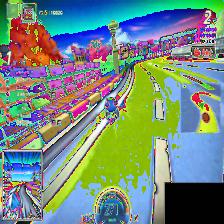

torch.Size([8, 300])
tensor([[False,  True,  True,  True,  True, False],
        [False,  True,  True,  True, False, False],
        [ True, False,  True, False, False, False],
        [ True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False],
        [ True,  True,  True, False,  True,  True],
        [ True,  True,  True,  True,  True, False]], device='cuda:0')
tensor(0, device='cuda:0')
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0.]])
tensor(0.6944, grad_fn=<CopyBackwards>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [15]:
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

display(to_img(inputs[0]))

inputs = inputs.to(device)
labels = labels.to(device)
past_inputs = past_inputs.to(device)
print(past_inputs.shape)
outs = model(inputs, past_inputs)
print(outs > 0.5)
print((((outs > 0.5) == labels).sum(axis=1) == 6).sum())
loss = criterion(outs, labels)
print(labels.cpu())
print(loss.cpu())

# 학습 진행상황 확인을 위한 wandb 설정

In [16]:
!pip install wandb

     |████████████████████████████████| 1.8MB 12.3MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 133kB 37.1MB/s 
     |████████████████████████████████| 174kB 37.6MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=1a218e871b4ffb046ce32a34231bb43a5ffd3cae141759d46c393a78fe339a1f
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=1ec13da17e245ca6375971d6428d5a1f24d207eb5de0d6d504707bd7e230d7f6
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [17]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [18]:
config = {}
config['n_epochs'] = num_epochs
config['batch_sze'] = batch_size
config['lr'] = lr


wandb.init(project="boomhill24_1", config=config)

wandb: Currently logged in as: junhyeokk (use `wandb login --relogin` to force relogin)


# 학습 진행 및 저장

In [19]:
for epoch in range(num_epochs):
  model.train()
  # loss_value = 0
  # matches = 0
  
  for idx, train_batch in enumerate(loader):
    inputs, past_inputs, labels = train_batch
    inputs = inputs.to(device)
    past_inputs = past_inputs.to(device)
    labels = labels.to(device)

    outs = model(inputs, past_inputs)
    preds = (outs > 0.5)
    loss = criterion(outs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # loss_value += loss.item()
    # matches += (preds == labels).sum().item()
    matches = ((preds == labels).sum(axis = 1) == 6).sum()

    wandb.log({"epoch" : epoch, "training_loss" : loss.item(), "training_acc" : matches / batch_size})
    if (idx + 1) % log_interval == 0:
    #   train_loss = loss_value / log_interval
    #   # train_acc = matches / batch_size / log_interval
    #   current_lr = scheduler.get_last_lr()
      print(
          f"Epoch[{epoch}/{num_epochs}]({idx + 1}/{len(loader)}) || "
          # f"training loss {train_loss:4.4} || lr {current_lr}"
          # f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
      )

      # loss_value = 0
      # matches = 0

    scheduler.step()
    
  torch.save(model.state_dict(), save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[0/20](10/123) || 
Epoch[0/20](20/123) || 
Epoch[0/20](30/123) || 
Epoch[0/20](40/123) || 
Epoch[0/20](50/123) || 
Epoch[0/20](60/123) || 
Epoch[0/20](70/123) || 
Epoch[0/20](80/123) || 
Epoch[0/20](90/123) || 
Epoch[0/20](100/123) || 
Epoch[0/20](110/123) || 
Epoch[0/20](120/123) || 
Epoch[1/20](10/123) || 
Epoch[1/20](20/123) || 
Epoch[1/20](30/123) || 
Epoch[1/20](40/123) || 
Epoch[1/20](50/123) || 
Epoch[1/20](60/123) || 
Epoch[1/20](70/123) || 
Epoch[1/20](80/123) || 
Epoch[1/20](90/123) || 
Epoch[1/20](100/123) || 
Epoch[1/20](110/123) || 
Epoch[1/20](120/123) || 
Epoch[2/20](10/123) || 
Epoch[2/20](20/123) || 
Epoch[2/20](30/123) || 
Epoch[2/20](40/123) || 
Epoch[2/20](50/123) || 
Epoch[2/20](60/123) || 
Epoch[2/20](70/123) || 
Epoch[2/20](80/123) || 
Epoch[2/20](90/123) || 
Epoch[2/20](100/123) || 
Epoch[2/20](110/123) || 
Epoch[2/20](120/123) || 
Epoch[3/20](10/123) || 
Epoch[3/20](20/123) || 
Epoch[3/20](30/123) || 
Epoch[3/20](40/123) || 
Epoch[3/20](50/123) || 
Epoch[3